# Q3
Predict the likelihood of delay for the list of shipments in “New_bookings.csv” dataset.

# 1. Library Import

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import matplotlib.pyplot as plt
import helper

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, log_loss


from datetime import datetime
from datetime import timedelta

# 2. Data Loading

In [2]:
df_GPS = pd.read_csv('Data/GPS_data.csv')
df_bookings = pd.read_csv('Data/Shipment_bookings.csv')
df_new_bookings = pd.read_csv('Data/New_bookings.csv')
print(df_bookings.shape, df_new_bookings.shape, df_GPS.shape)

(3245, 15) (1000, 15) (641662, 4)


In [3]:
df = pd.read_csv('Data/bookings_processed.csv')

# 3. Predictive Model
Predict the likelihood of delay for the list of shipments

In [4]:
df_train = df.copy()

## 3.1 Data Processing

In [5]:
# convert time strings to date_time

# convert to datetime format 
date_cols = ['FIRST_COLLECTION_SCHEDULE_EARLIEST', 
             'FIRST_COLLECTION_SCHEDULE_LATEST', 
             'LAST_DELIVERY_SCHEDULE_EARLIEST',
            'LAST_DELIVERY_SCHEDULE_LATEST']

for data in [df_new_bookings, df_train]:
    for i in date_cols:
        data[i]=pd.to_datetime(data[i])

In [6]:
# define predictors
not_predictors = ['SHIPMENT_NUMBER',
                  'Unnamed: 0', 
                  'PROJECT_ID', 
                  'CARRIER_DISPLAY_ID',
                  'RECORD_TIMESTAMP',
                  'LAT', 
                  'LON', 
                  'POSTCODE',
                  'almost_on_time',
                  'on_time',
                  'GPS_coord',
                  'last_delivery_coord',
                  'FIRST_COLLECTION_SCHEDULE_EARLIEST',
                  'FIRST_COLLECTION_SCHEDULE_LATEST',
                  'LAST_DELIVERY_SCHEDULE_EARLIEST',
                  'LAST_DELIVERY_SCHEDULE_LATEST',
                  'almost_reached_delivery_loc',
                  'reached_delivery_loc'
                 ]
predictors = np.setdiff1d(df_train.columns, not_predictors)
predictors

array(['FIRST_COLLECTION_LATITUDE', 'FIRST_COLLECTION_LONGITUDE',
       'FIRST_COLLECTION_POST_CODE', 'LAST_DELIVERY_LATITUDE',
       'LAST_DELIVERY_LONGITUDE', 'LAST_DELIVERY_POST_CODE',
       'VEHICLE_BUILD_UP', 'VEHICLE_SIZE'], dtype=object)

## 3.2 EDA

In [7]:
df_new_bookings['VEHICLE_SIZE'].value_counts()

VEHICLE_SIZE
Tractor Unit    806
3.5T Van        161
3.5 T Van        17
18T Rigid         7
7.5T Rigid        5
7.5 T             4
Name: count, dtype: int64

In [8]:
df_new_bookings['VEHICLE_BUILD_UP'].value_counts()

VEHICLE_BUILD_UP
Curtain-Side 13.6M Trailer    667
Box                           140
LWB Van                        83
Box 44ft                       52
Temperature-Controlled         29
Tractor Only 6x2                9
Curtain Side                    9
Mega / High Cube Trailer        6
High Security                   3
Luton Tail Lift                 2
Name: count, dtype: int64

In [9]:
df_test = df_new_bookings.copy()

## 3.3 Feature Engineering

In [10]:
# calculate the difference between collection & delivery lats & lons

datasets = [df_train, df_test]


for data in datasets:
    
    # calculate durations between collection & delivery
    d1 = data['FIRST_COLLECTION_SCHEDULE_EARLIEST'] 
    d2 = data['LAST_DELIVERY_SCHEDULE_EARLIEST']
    d3 = data['FIRST_COLLECTION_SCHEDULE_LATEST']
    d4 = data['LAST_DELIVERY_SCHEDULE_LATEST']
    # calculate durations between collection & delivery
    d1 = data['FIRST_COLLECTION_SCHEDULE_EARLIEST'] 
    d2 = data['LAST_DELIVERY_SCHEDULE_EARLIEST']
    d3 = data['FIRST_COLLECTION_SCHEDULE_LATEST']
    d4 = data['LAST_DELIVERY_SCHEDULE_LATEST']

    data['duration1']=(d2-d1).dt.total_seconds()
    data['duration2']=(d4-d3).dt.total_seconds()
    data['duration_longest']=(d4-d1).dt.total_seconds()

    data['collection_window'] = (data['FIRST_COLLECTION_SCHEDULE_LATEST'] - data['FIRST_COLLECTION_SCHEDULE_EARLIEST']).dt.total_seconds()
    data['delivery_window'] = (data['LAST_DELIVERY_SCHEDULE_LATEST'] - data['LAST_DELIVERY_SCHEDULE_EARLIEST']).dt.total_seconds()
    
    data['lat_diff']=abs(data['LAST_DELIVERY_LATITUDE'] - data['FIRST_COLLECTION_LATITUDE']) # latitude difference
    data['lon_diff'] = abs(data['LAST_DELIVERY_LONGITUDE'] - data['FIRST_COLLECTION_LONGITUDE']) # longitude difference

In [11]:
# add to list of predictors
predictors=list(predictors)
predictors.extend(['lat_diff', 'lon_diff', 'duration1', 'duration2', 'duration_longest'])
predictors

['FIRST_COLLECTION_LATITUDE',
 'FIRST_COLLECTION_LONGITUDE',
 'FIRST_COLLECTION_POST_CODE',
 'LAST_DELIVERY_LATITUDE',
 'LAST_DELIVERY_LONGITUDE',
 'LAST_DELIVERY_POST_CODE',
 'VEHICLE_BUILD_UP',
 'VEHICLE_SIZE',
 'lat_diff',
 'lon_diff',
 'duration1',
 'duration2',
 'duration_longest']

## 3.4 Prepare Data for Modelling

In [12]:
df = df_train.copy()

In [13]:
for i in ['FIRST_COLLECTION_POST_CODE', 'LAST_DELIVERY_POST_CODE']:
    df[i] = df[i].astype(str)

In [14]:
# splitting the dataset into  independent variable X and dependent(target) y
X = df[predictors]
y = df['almost_on_time']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [17]:
# separate categorical & numerical features

num_feats = ['FIRST_COLLECTION_LATITUDE',
 'FIRST_COLLECTION_LONGITUDE',
 'LAST_DELIVERY_LATITUDE',
 'LAST_DELIVERY_LONGITUDE',
 'duration1',
 'duration2',
 'duration_longest',
 'lat_diff',
 'lon_diff'
            ]

cat_feats = ['FIRST_COLLECTION_POST_CODE', 'LAST_DELIVERY_POST_CODE', 'VEHICLE_BUILD_UP', 'VEHICLE_SIZE']

In [18]:
df[num_feats].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3241 entries, 0 to 3240
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   FIRST_COLLECTION_LATITUDE   3241 non-null   float64
 1   FIRST_COLLECTION_LONGITUDE  3241 non-null   float64
 2   LAST_DELIVERY_LATITUDE      3241 non-null   float64
 3   LAST_DELIVERY_LONGITUDE     3241 non-null   float64
 4   duration1                   3241 non-null   float64
 5   duration2                   3241 non-null   float64
 6   duration_longest            3241 non-null   float64
 7   lat_diff                    3241 non-null   float64
 8   lon_diff                    3241 non-null   float64
dtypes: float64(9)
memory usage: 228.0 KB


In [19]:
df[num_feats].head()

,FIRST_COLLECTION_LATITUDE,FIRST_COLLECTION_LONGITUDE,LAST_DELIVERY_LATITUDE,LAST_DELIVERY_LONGITUDE,duration1,duration2,duration_longest,lat_diff,lon_diff
0,52.315672,-0.157664,55.877803,-3.648558,259800.0,260700.0,261600.0,3.562131,3.490894
1,53.764125,-1.740145,51.398851,-1.231993,56400.0,60960.0,66960.0,2.365274,0.508152
2,53.767302,-1.746560,51.660700,-0.022247,20580.0,27780.0,33780.0,2.106602,1.724313
3,51.779657,-0.772897,52.888113,-0.634948,23400.0,23400.0,25200.0,1.108456,0.137949
4,52.334853,-1.180450,55.735089,-4.168719,32400.0,32340.0,35940.0,3.400236,2.988269


In [20]:
# define target variable
target = 'almost_on_time'

## 3.5 Modelling

### 3.5.1 Train & Fit - Logistic Regression

In [21]:
# Create the column transformer with one-hot encoding for categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_feats),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_feats)
    ]
)

# Create the pipeline with preprocessing and logistic regression model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['FIRST_COLLECTION_LATITUDE',
                                                   'FIRST_COLLECTION_LONGITUDE',
                                                   'LAST_DELIVERY_LATITUDE',
                                                   'LAST_DELIVERY_LONGITUDE',
                                                   'duration1', 'duration2',
                                                   'duration_longest',
                                                   'lat_diff', 'lon_diff']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['FIRST_COLLECTION_POST_CODE',
                                                   'LAST_DELIVERY_POST_CODE',
                                                   'VEHICLE_BUILD_UP',
                                                   'VEHICLE_SIZE'])])),
                ('classifier', LogisticRegression())])

### 3.5.1 Model Selection - Logistic Regression, Random Forest & SVM

C:\Users\Lenovo IdeaCentre\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo IdeaCentre\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo IdeaCentre\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

     Delayed       0.88      1.00      0.94       570
     On-Time       0.00      0.00      0.00        79

    accuracy                           0.88       649
   macro avg       0.44      0.50      0.47       649
weighted avg       0.77      0.88      0.82       649

AUC for Logistic Regression: 0.61
Classification Report for Random Forest:
              precision    recall  f1-score   support

     Delayed       0.92      0.94      0.93       570
     On-Time       0.45      0.38      0.41        79

    accuracy                           0.87       649
   macro avg       0.68      0.66      0.67       649
weighted avg       0.86      0.87      0.86       649

AUC for Random Forest: 0.79
Classification Report for Support Vector Machine:
              precision    recall  f1-score   support

     Delayed       0.88      1.00      0.94       570
     On-Time       0.00      0.00    

C:\Users\Lenovo IdeaCentre\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo IdeaCentre\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo IdeaCentre\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


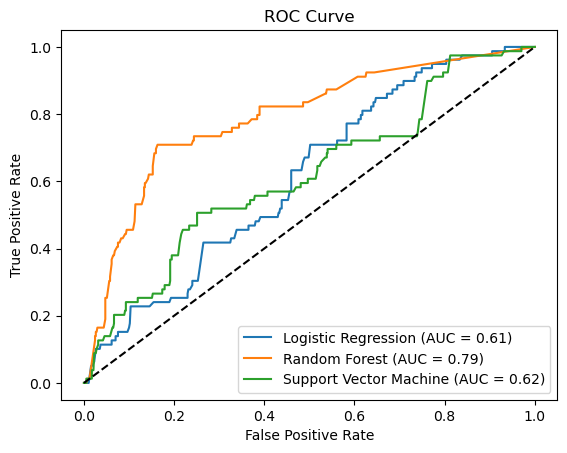

In [28]:
# Create the column transformer with one-hot encoding for categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_feats),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_feats)
    ]
)

# Create the pipeline with preprocessing and logistic regression model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a dictionary of models to compare
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(probability=True)  # Enable probability estimates for AUC calculation
}

best_model = None
best_auc = 0

# Train the models and evaluate their performance
for model_name, model in models.items():
    # Create the pipeline with preprocessing and the current model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = pipeline.predict(X_test)
    y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
    
    # Generate classification report
    report = classification_report(y_test, y_pred, target_names=['Delayed','On-Time'])
    print(f"Classification Report for {model_name}:\n{report}")
    
    # Calculate AUC
    auc_score = roc_auc_score(y_test, y_pred_prob)
    print(f"AUC for {model_name}: {auc_score:.2f}")
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})')
    
    # Keep track of the best model
    if auc_score > best_auc:
        best_auc = auc_score
        best_model = pipeline

# Plot settings
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [23]:
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['FIRST_COLLECTION_LATITUDE',
                                                   'FIRST_COLLECTION_LONGITUDE',
                                                   'LAST_DELIVERY_LATITUDE',
                                                   'LAST_DELIVERY_LONGITUDE',
                                                   'duration1', 'duration2',
                                                   'duration_longest',
                                                   'lat_diff', 'lon_diff']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['FIRST_COLLECTION_POST_CODE',
                                                   'LAST_DELIVERY_POST_CODE',
                                                   'VEHICLE_BUILD_UP',
                                                   'VEHICLE_SIZE'])])),
                ('classifier', RandomForestClassifier())])

__Comments__
* Random Forest is the winning model as it has the highest AUC: 0.77
* It also scores the highest in precision & f1-score and 2nd highest on recall
* High number of False Negatives (high recall) is better than having high number of False Positives (high precision) 
* This is because it's less detrimental to shippers to falsely labelling on-time shipments than falsely labelling delayed ones

# 4. Prediction

In [29]:
df_test = df_test[X_test.columns]
df_test.columns

Index(['FIRST_COLLECTION_LATITUDE', 'FIRST_COLLECTION_LONGITUDE',
       'FIRST_COLLECTION_POST_CODE', 'LAST_DELIVERY_LATITUDE',
       'LAST_DELIVERY_LONGITUDE', 'LAST_DELIVERY_POST_CODE',
       'VEHICLE_BUILD_UP', 'VEHICLE_SIZE', 'lat_diff', 'lon_diff', 'duration1',
       'duration2', 'duration_longest'],
      dtype='object')

In [30]:
# Predict using the trained model
unseen_predictions = best_model.predict(df_test)
unseen_predictions_prob = best_model.predict_proba(df_test)[:, 1]

# Combine predictions and their probabilities into a DataFrame
results = df_test.copy()
results['Predicted_Class'] = unseen_predictions
results['Prediction_Probability'] = unseen_predictions_prob

In [31]:
results.head()

,FIRST_COLLECTION_LATITUDE,FIRST_COLLECTION_LONGITUDE,FIRST_COLLECTION_POST_CODE,LAST_DELIVERY_LATITUDE,LAST_DELIVERY_LONGITUDE,LAST_DELIVERY_POST_CODE,VEHICLE_BUILD_UP,VEHICLE_SIZE,lat_diff,lon_diff,duration1,duration2,duration_longest,Predicted_Class,Prediction_Probability
0,53.407411,-6.238118,DUBLIN,53.537912,-1.033570,DN3 3FF,Box,Tractor Unit,0.130501,5.204548,64800.0,50400.0,68400.0,0,0.118817
1,53.882244,-1.267537,LS24 9SD,54.474078,-6.104285,BT26 6JJ,Curtain-Side 13.6M Trailer,Tractor Unit,0.591834,4.836748,336600.0,3600.0,338400.0,0,0.020000
2,53.407411,-6.238118,DUBLIN,53.537912,-1.033570,DN3 3FF,Curtain-Side 13.6M Trailer,Tractor Unit,0.130501,5.204548,84600.0,84600.0,86400.0,0,0.040000
3,53.293393,-1.074008,S80 3FY,53.294121,-6.441900,DUBLIN,Curtain-Side 13.6M Trailer,Tractor Unit,0.000728,5.367892,190860.0,189120.0,192660.0,0,0.040000
4,53.293393,-1.074008,S80 3FY,54.664518,-5.932184,BT36 7LQ,Curtain-Side 13.6M Trailer,Tractor Unit,1.371125,4.858176,350700.0,348960.0,352500.0,1,0.600000


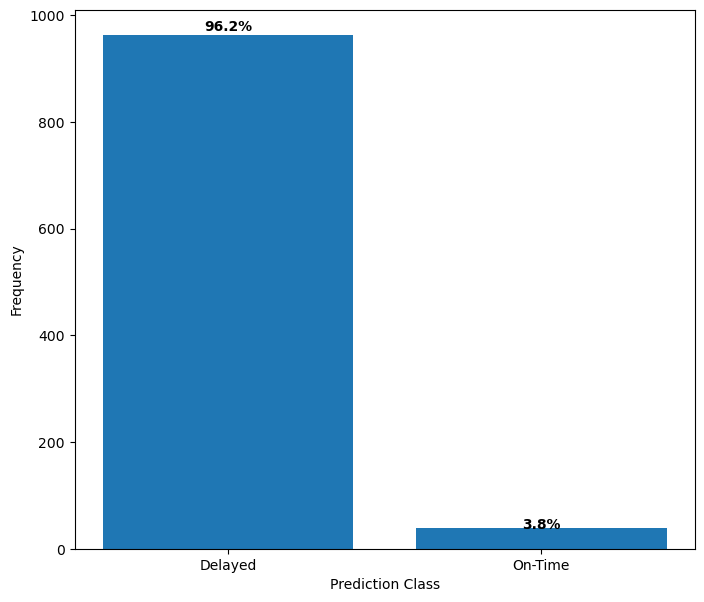

In [34]:
# # Plot prediction class distribution
helper.plot_class_distribution('Predicted_Class', results, 'Prediction Class', [0, 1], ['Delayed', 'On-Time'])

# 5. Save Results

In [33]:
results.to_csv('Data/prediction.csv')